Data collection and preparation

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import zipfile

# Unzip the file
with zipfile.ZipFile("data.csv.zip", 'r') as zip_ref:
    zip_ref.extractall("unzipped_data")  # This creates a folder with the CSV inside

# List files to see actual name
import os
print(os.listdir("unzipped_data"))  # Check the exact CSV name



['data.csv']


In [2]:
df = pd.read_csv("/content/unzipped_data/data.csv",encoding='ISO-8859-1')
print(df.columns)

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')


In [3]:
import pandas as pd

# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Remove rows with missing CustomerID or Quantity <= 0
df = df[df['CustomerID'].notnull()]
df = df[df['Quantity'] > 0]

# Calculate TotalAmount = Quantity * UnitPrice
df['TotalAmount'] = df['Quantity'] * df['UnitPrice']

# Snapshot date: usually the day after the last transaction
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

# Calculate RFM
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,   # Recency
    'InvoiceNo': 'nunique',                                     # Frequency
    'TotalAmount': 'sum'                                        # Monetary
}).reset_index()

# Rename columns
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

# View result
print(rfm.head())


   CustomerID  Recency  Frequency  Monetary
0     12346.0      326          1  77183.60
1     12347.0        2          7   4310.00
2     12348.0       75          4   1797.24
3     12349.0       19          1   1757.55
4     12350.0      310          1    334.40


In [4]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_df = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])


In [5]:
from sklearn.decomposition import PCA

# Reduce dimensions to 2 for visualization and clustering
pca = PCA(n_components=2)
pca_df = pca.fit_transform(scaled_df)


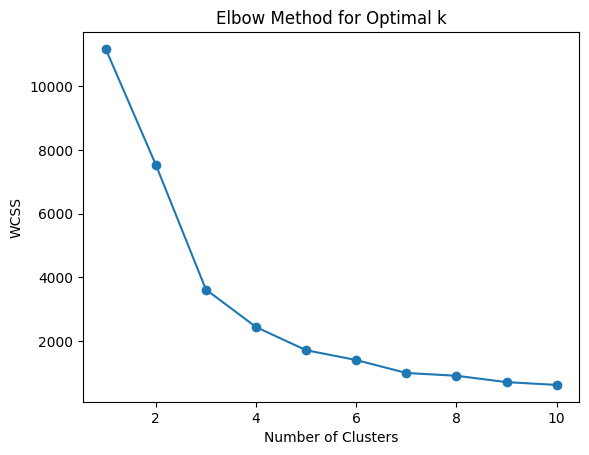

In [6]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_df)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss, marker='o')
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS")
plt.show()


In [7]:
from sklearn.metrics import silhouette_score

# Let's say k=4 based on elbow method
kmeans = KMeans(n_clusters=4, random_state=42)
labels = kmeans.fit_predict(pca_df)

# Evaluate with Silhouette Score
score = silhouette_score(pca_df, labels)
print(f"Silhouette Score: {score:.2f}")


Silhouette Score: 0.64


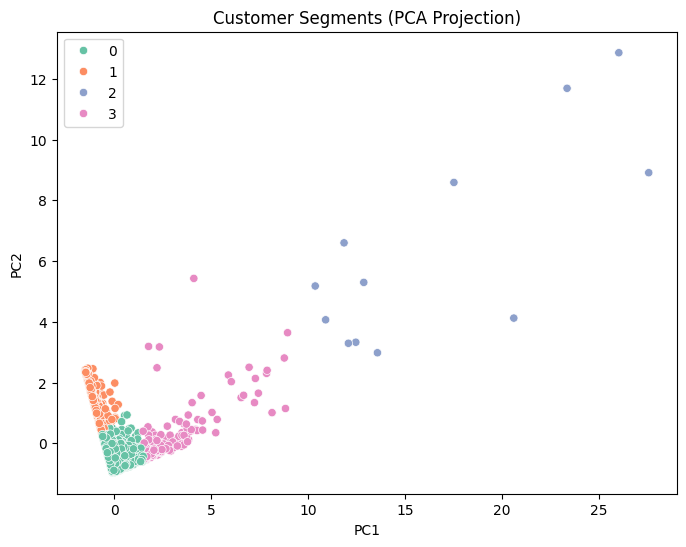

In [8]:
import seaborn as sns

rfm['Cluster'] = labels  # Add cluster to original RFM data

# Visualize clusters
plt.figure(figsize=(8,6))
sns.scatterplot(x=pca_df[:,0], y=pca_df[:,1], hue=labels, palette='Set2')
plt.title("Customer Segments (PCA Projection)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


In [9]:
# Cluster-wise average RFM values
print(rfm.groupby("Cluster")[['Recency', 'Frequency', 'Monetary']].mean())

# Export CSV
rfm.to_csv("clustered_customers.csv", index=False)


            Recency  Frequency       Monetary
Cluster                                      
0         43.278030   3.817563    1390.619013
1        247.756075   1.542056     479.202861
2          7.750000  87.000000  130361.308333
3         15.725146  23.748538   14870.613275


In [10]:
import joblib

joblib.dump(kmeans, "kmeans_model.pkl")
joblib.dump(pca, "pca_model.pkl")
joblib.dump(scaler, "scaler.pkl")


['scaler.pkl']